[*********************100%***********************]  1 of 1 completed
Best look-back period: 50
Best holding period: 1
Best Sharpe ratio: 6.522808002739007


<AxesSubplot:xlabel='Date'>

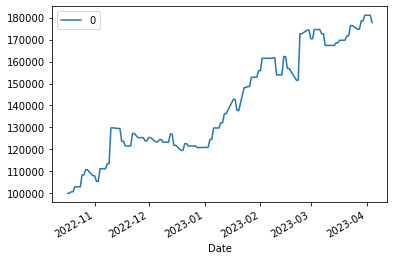

In [47]:
import pandas as pd
import numpy as np
import yfinance as yf

# set initial balance and load data

ticker = 'NVDA'
data = yf.download(ticker, start='2022-10-15', end='2023-04-05')
prices = data['Adj Close']
returns = prices.pct_change().fillna(0)

# set up look-back and holding periods
look_back_periods = [1, 3, 7, 20, 50]
holding_periods = [1, 3, 7, 20, 50, 100]

# initialize sharpe ratio and best parameters
sharpe_ratio = -np.inf
best_lb = None
best_hp = None
best_history=[]
# iterate through all combinations of look-back and holding periods
for lb in look_back_periods:
    for hp in holding_periods:
        balance = 100000
        # initialize variables for tracking trades and P&L
        trades = []
        position = 0
        pnl = []
        temp=np.inf
        # iterate through the price data
        liquidation=[]
        for i in range(len(prices)):
            
            # calculate momentum indicator
            momentum = returns.iloc[max(0, i-lb):i+1].mean()
            # check if we need to sell
            if position > 0 and i - temp >= hp:
                trades.append((prices.index[i], prices.iloc[i], 'SELL'))
                balance += prices.iloc[i] * position
                position = 0
                pnl.append(balance - 100000)
                
            # check if we need to buy
            elif balance>0 and momentum > 0:
                temp=i
                position = balance // prices.iloc[i]
                trades.append((prices.index[i], prices.iloc[i], 'BUY'))
                balance -= prices.iloc[i] * position
            liquidation.append(balance+position*prices.iloc[i])
        #print(liquidation)
        # calculate sharpe ratio for this combination of look-back and holding periods
        daily_returns = pd.Series(liquidation).pct_change().fillna(0)
        annualized_return = (1 + daily_returns.mean())**252 - 1
        annualized_volatility = daily_returns.std() * np.sqrt(252)
        sharpe = annualized_return / annualized_volatility
        # update best parameters if this sharpe ratio is higher
        if sharpe > sharpe_ratio:
            #print(liquidation)
            sharpe_ratio = sharpe
            best_lb = lb
            best_hp = hp
            best_history = liquidation
            
# print results
print('Best look-back period:', best_lb)
print('Best holding period:', best_hp)
print('Best Sharpe ratio:', sharpe_ratio)

# visualize historical return of the strategy
best_history=pd.DataFrame(np.array(best_history),index=prices.index)
best_history.plot()
